In [872]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import json

In [873]:
import tensorflow as tf

from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D;
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers

In [874]:
with open("tokenizer.json", "r") as jsonfile:
    tokenizer = json.load(jsonfile)

tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer)

In [875]:
with open("dados/tituloTratado.csv", "r") as csvfile:
    titulos = np.genfromtxt(csvfile, delimiter=",")
    titulos = titulos.astype(np.int32)

In [876]:
with open("dados/conteudoTratado.csv", "r") as csvfile:
    conteudos = np.genfromtxt(csvfile, delimiter=",")
    conteudos = conteudos.astype(np.int32)

In [877]:
size = len(conteudos)

xTrain = conteudos[0:int(size*0.8)]
xTest = conteudos[int(size*0.8):]

yTrain = titulos[0:int(size*0.8)]
yTest = titulos[int(size*0.8):]

In [878]:
vocab = len(tokenizer.word_index)

In [879]:
vocab

19567

In [880]:
maxTitle = max(len(tokens) for tokens in titulos)
maxContent = max(len(tokens) for tokens in conteudos)

In [881]:
class SamplingLayer(layers.Layer):
  """Reparameterization Trick z = mu + sigma * epsilon"""

  def call(self, inputs):
    zMean, zLogVar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return zMean + tf.exp(0.5 * zLogVar) * epsilon

In [882]:
def Encoder(latentDim, encoderInputs):
    
  l1 = keras.models.Sequential([
    layers.Embedding(vocab, 128, input_length=maxContent),
    layers.Conv1D(128, 3, activation="relu", strides=1, padding="same"),
    layers.MaxPooling1D(3),
    layers.Conv1D(64, 3, activation="relu", strides=1, padding="same"),
    layers.MaxPooling1D(3),
    layers.Flatten(),
    layers.Dense(256, activation="relu")
  ])

  x = l1(encoderInputs)

  zMean = layers.Dense(latentDim, name="z_mean")(x)
  zLogVar = layers.Dense(latentDim, name="z_log_var")(x)

  z = SamplingLayer()([zMean, zLogVar])

  return keras.Model(encoderInputs, [zMean, zLogVar, z], name="encoder")

encoderInputs = keras.Input(shape=(maxContent, 1))
encoder = Encoder(2, encoderInputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 2268, 1)]            0         []                            
                                                                                                  
 sequential_8 (Sequential)   (None, 256)                  6707520   ['input_10[0][0]']            
                                                                                                  
 z_mean (Dense)              (None, 2)                    514       ['sequential_8[0][0]']        
                                                                                                  
 z_log_var (Dense)           (None, 2)                    514       ['sequential_8[0][0]']        
                                                                                            

In [883]:
def Decoder(latentInputs):

  l1 = keras.models.Sequential([
    layers.Dense(maxTitle, activation="relu", input_shape=(latentInputs.shape[1],)),
    layers.Reshape((maxTitle, 1)),
    layers.Conv1DTranspose(128, 3, activation="relu", strides=1, padding="same"),
    layers.Conv1DTranspose(64, 3, activation="relu", strides=1, padding="same"),
    layers.Conv1DTranspose(1, 3, activation="sigmoid", padding="same", input_shape=(None, maxTitle))
  ])

  return keras.Model(latentInputs, l1(latentInputs), name="decoder")

latentInputs = keras.Input(shape=(2,))
decoder = Decoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 2)]               0         
                                                                 
 sequential_9 (Sequential)   (None, 18, 1)             25399     
                                                                 
Total params: 25399 (99.21 KB)
Trainable params: 25399 (99.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [884]:
def reconstructionLoss(data, reconstructed):
  return keras.losses.binary_crossentropy(data, reconstructed)   

In [885]:
def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
        -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
        axis=1
  )

In [886]:
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)
  loss2 = klDivergenceLoss(zMean, zLogVar)
  klWeight = 3.0
  return  loss1, loss2, loss1 + klWeight * loss2

In [887]:
print(xTrain.shape, "\n", yTrain.shape)

(396, 2268) 
 (396, 18)


In [888]:
xTrain = np.expand_dims(xTrain, -1).astype("float32") / vocab
yTrain = np.expand_dims(yTrain, -1).astype("float32") / vocab

In [889]:
xTest = np.expand_dims(xTest, -1).astype("float32") / vocab
yTest = np.expand_dims(yTest, -1).astype("float32") / vocab

In [890]:
print(xTrain.shape, "\n", yTrain.shape)

(396, 2268, 1) 
 (396, 18, 1)


In [901]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder

    self.totalLossTracker = keras.metrics.Mean(name="total_loss")
    self.ceLossTracker = keras.metrics.Mean(name="ce_loss")
    self.klLossTracker = keras.metrics.Mean(name="kl_loss")
    
  @property
  def metrics(self):
    return [
        self.totalLossTracker,
        self.ceLossTracker,
        self.klLossTracker
    ]

  def train_step(self, data):

    x, y = data[0]

    with tf.GradientTape() as tape:
        
        zMean, zLogVar, z = self.encoder(x)
        reconstruction = self.decoder(z)

        ceLoss, klLoss, totalLoss = calcTotalLoss(y, reconstruction, zMean, zLogVar)

    grads = tape.gradient(totalLoss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)

    return {
        "total_loss": self.totalLossTracker.result(),
        "ce_loss": self.ceLossTracker.result(),
        "kl_loss": self.klLossTracker.result()
    }

In [892]:
data = [xTrain, yTrain]

In [893]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
history = vae.fit(data, epochs=8, batch_size=1)

Epoch 1/8
396/396 [==============================] - 22s 51ms/step - total_loss: 0.2839 - ce_loss: 0.2836 - kl_loss: 1.1813e-04
Epoch 2/8
396/396 [==============================] - 20s 50ms/step - total_loss: 0.2531 - ce_loss: 0.2531 - kl_loss: 3.7559e-06
Epoch 3/8
396/396 [==============================] - 20s 50ms/step - total_loss: 0.2466 - ce_loss: 0.2466 - kl_loss: 6.0667e-06
Epoch 4/8
396/396 [==============================] - 20s 51ms/step - total_loss: 0.2423 - ce_loss: 0.2423 - kl_loss: 3.3044e-06
Epoch 5/8
396/396 [==============================] - 19s 49ms/step - total_loss: 0.2407 - ce_loss: 0.2407 - kl_loss: 2.4681e-06
Epoch 6/8
396/396 [==============================] - 19s 47ms/step - total_loss: 0.2408 - ce_loss: 0.2408 - kl_loss: 1.9580e-06
Epoch 7/8
396/396 [==============================] - 19s 47ms/step - total_loss: 0.2397 - ce_loss: 0.2397 - kl_loss: 1.9283e-06
Epoch 8/8
396/396 [==============================] - 19s 48ms/step - total_loss: 0.2397 - ce_loss: 0.239

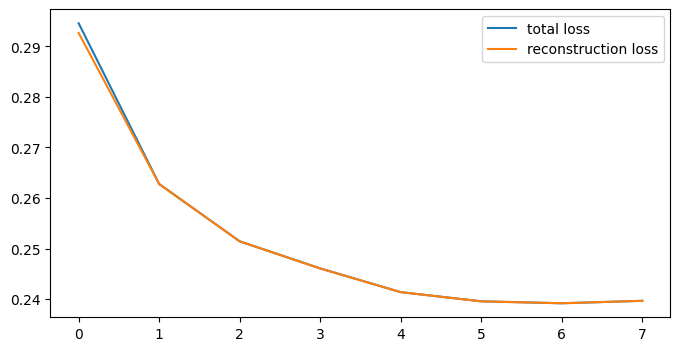

In [825]:
plt.figure(figsize=(8, 4))
plt.plot(history.history.get('total_loss'), label="total loss")
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")
#plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

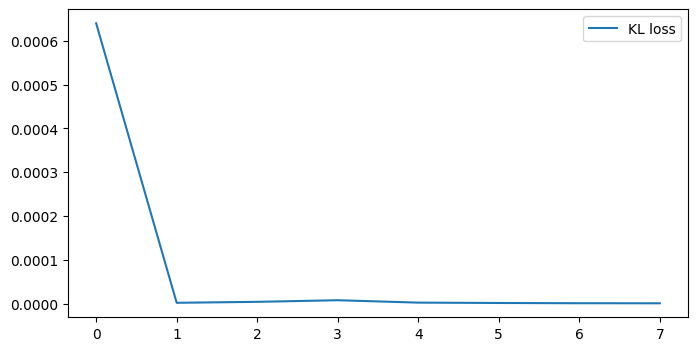

In [826]:
plt.figure(figsize=(8, 4))
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

In [895]:
plt.figure(figsize=(8, 4))
plt.plot(history.history["accuracy"], label="accuracy")
plt.legend();

KeyError: 'accuracy'

<Figure size 800x400 with 0 Axes>

In [856]:
idx = 12
inputPredict = xTest[idx]
inputPredict = inputPredict.reshape(1, maxContent)

In [857]:
z = vae.encoder.predict([inputPredict])[2]

1/1 [==============================] - 0s 30ms/step


In [858]:
#z = np.random.normal(loc=0, scale=4, size=(1,2))

In [859]:
z

array([[ 0.5869211 , -0.36085686]], dtype=float32)

In [860]:
teste = vae.decoder.predict(z)

1/1 [==============================] - 0s 52ms/step


In [861]:
teste = teste.reshape(maxTitle)

In [862]:
teste*vocab

array([2665.2825  , 3395.      , 2673.447   , 2673.447   , 2673.447   ,
       2673.447   , 2673.447   , 2669.0999  , 2620.8486  , 2334.134   ,
       1743.3661  , 1084.6158  ,  462.63245 ,  303.9235  ,  135.1092  ,
         86.89649 ,   25.181368,   25.019518], dtype=float32)

In [863]:
prediction = (teste*vocab).tolist()
for x in range(maxTitle):
    prediction[x] = round(prediction[x])

predictionsText = tokenizer.sequences_to_texts([prediction])

In [864]:
content = xTest[idx].reshape(maxContent)
content = (content*vocab).tolist()

for x in range(maxContent):
    content[x] = round(content[x])

content = tokenizer.sequences_to_texts([content])

In [865]:
tittle = yTest[idx].reshape(maxTitle)
tittle = (tittle*vocab).tolist()

for x in range(maxTitle):
    tittle[x] = round(tittle[x])

tittle = tokenizer.sequences_to_texts([tittle])

In [866]:
tittle

['junior assunção encara alejandro solano no xfci 5 brasil em junho']

In [867]:
content

['o lutador pernambucano junior assunção que é radicado no espírito santo foi confirmado na luta principal do evento xfci 5 brasil marcado para o dia 7 de junho em são paulo a organização norte americana divulgou o card completo e junior que é irmão do lutador do ufc raphael assunção encara o costa riquenho alejandro mandarina solano o duelo acontece na categoria peso pena até 65 7 kg e aparece com status de super luta da noite que tem mais seis combates confirmados e mais dois ainda em fase de definição dos atletas com 32 anos e um cartel de 14 vitórias e cinco derrotas junior assunção já teve duas passagens pelo ufc entre os anos de 2006 e 2007 retornando em 2011 esta também é a segunda passagem do lutador pelo xtreme fighting championships xfc onde lutou em 2010 já alejandro solano 19 9 e 1nc no mma é mais velho e tem 36 anos o lutador de costa rica atuou em eventos brasileiros como jungle fight e shotoo brasil ambos em 2012 o evento xfci 5 brasil também terá as finais dos torneios 

In [868]:
predictionsText

['west experiente definitiva definitiva definitiva definitiva definitiva gomi sr concorrentes ibc consumo globo pelos desde bem dos dos']